In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import multiprocessing as mp
from itertools import repeat
%matplotlib inline

In [2]:
#Convention
# 1 -> spin up
# -1 -> spin down

In [162]:
#Set data path
train_data = '../../data/Ising/train/'
test_data = '../../data/Ising/test/'
valid_data = '../../data/Ising/valid/'

In [2]:
#Initialize array
def createArray(N,p):
    #Create a square array of size N+2 (the extra row/column are ghosts for periodic BC)
    mat = np.zeros((N+2,N+2), dtype=int)
    mat[1:N+1,1:N+1] = np.random.randint(0,high=2,size=(N,N))
    
    #set the BC ghosts
    mat[:,0] = mat[:,N]
    mat[:,N+1] = mat[:,1]
    
    mat[0,:] = mat[N,:]
    mat[N+1,:] = mat[1,:]
    
    mat[mat==0] = -1
    
    #Set corner BCs
    mat[0,0] = 0
    mat[-1,-1] = 0
    mat[0,-1] = 0
    mat[-1,0] = 0
    
    return mat

In [3]:
#Iterate function
def iterate(mat,T,calcE):
    n,_ = mat.shape
    N = n-2
    
    order1 = np.arange(1,N+1)
    order2 = np.arange(1,N+1)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    #updateMat=np.copy(mat)
    updateMat=mat
    avgE = 0.0
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_potential = spin_current*(-1)
            E_current = -spin_current*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
            E_potential = -spin_potential*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
            E_diff = E_potential - E_current
            if E_diff < 0:
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            #else:
                #avgE+=float(E_current)
            updateMat[:,0] = updateMat[:,N]
            updateMat[:,N+1] = updateMat[:,1]
    
            updateMat[0,:] = updateMat[N,:]
            updateMat[N+1,:] = updateMat[1,:]

    if calcE:        
        for i in order1:
            for j in range(1,N+1):
                spin_final = mat[i,j]
                E_final = -spin_final*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
                avgE+=float(E_final)
    
        avgE/=float(N**2)                   
        return updateMat, avgE
    else:
        return updateMat
            

In [4]:
#Iterate function for triangular lattice 
def iterateTri(mat,T,calcE):
    n,_ = mat.shape
    N = n-2
    
    order1 = np.arange(1,N+1)
    order2 = np.arange(1,N+1)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    
    updateMat=mat
    avgE = 0.0
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_potential = spin_current*(-1)
            E_current = -spin_current*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1]+mat[i+1,j+1]+mat[i-1,j-1])
            E_potential = -spin_potential*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1]+mat[i+1,j+1]+mat[i-1,j-1])
            E_diff = E_potential - E_current
            if E_diff < 0:
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            #else:
                #avgE+=float(E_current)
            updateMat[:,0] = updateMat[:,N]
            updateMat[:,N+1] = updateMat[:,1]
    
            updateMat[0,:] = updateMat[N,:]
            updateMat[N+1,:] = updateMat[1,:]

    if calcE:        
        for i in order1:
            for j in range(1,N+1):
                spin_final = mat[i,j]
                E_final = -spin_final*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
                avgE+=float(E_final)
    
        avgE/=float(N**2)                   
        return updateMat, avgE
    else:
        return updateMat

In [140]:
def calcCorr(mat, L, dist):
    # Calculate the correlation function for r = dist
    # dist should be less than L/2
    # Samples from the diagonal
    products1 = 0
    avg1 = 0
    avg2 = 0
    for i in range(1,L+1):
        for j in range(1,L+1):
            idx1 = (i+dist)%L
            idx2 = (i-dist)%L
            idx3 = (j+dist)%L
            idx4 = (j-dist)%L
            products1 += mat[i,j]*(mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
            avg1 += mat[i,j]
            avg2 += (mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
        
    products1/=(4.0*L*L)
    avg1/= float(L*L)
    avg2/= (4.0*L*L)
    corrFunc = products1 - avg1*avg2
    return dist, corrFunc

In [121]:
def corrLength(corrs):
    dist = np.arange(1,len(corrs)+1,dtype=float)
    m,b = np.polyfit(dist,np.log(corrs),1)
    
    length = -1.0/m
    return length

In [6]:
def simulate(mat,T,steps):
    #Runs MC for number of steps
    calcE=False
    for step in range(steps):
        mat = iterate(mat,T,calcE)
    
    #return mat

In [7]:
def generateSamples(T,L,steps,samples,dirPath):
    for i in range(1,samples+1):
        mat = createArray(L,1)
        simulate(mat,T,steps)
        
        if T<2.27:
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,f"{category}_{T:.1f}_{i}_")
        np.save(path,mat[1:-1,1:-1])

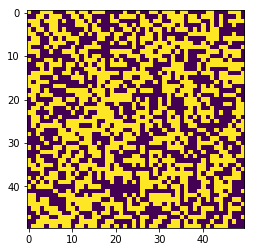

In [141]:
mat=createArray(50,1)
plt.imshow(mat[1:-1,1:-1])

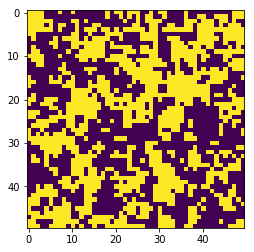

In [142]:
simulate(mat,3.5,300)
plt.imshow(mat[1:-1,1:-1])

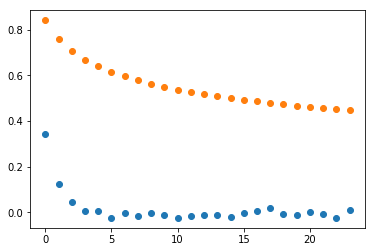

In [143]:
corr = np.zeros(int(50/2))
for i in range(1,int(50/2)):
    _,corr[i] = calcCorr(mat,50,i)

corr_theory = np.fromfunction(lambda i : (i+1.0)**-0.25, shape=(25,),dtype=float)
plt.plot(corr[1:],'o')
plt.plot(corr_theory[1:],'o')

In [137]:
corrLength(corr[1:])

/home/daniel/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daniel/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


LinAlgError: SVD did not converge in Linear Least Squares

In [103]:
mat=iterateTri(mat,0.5,False)

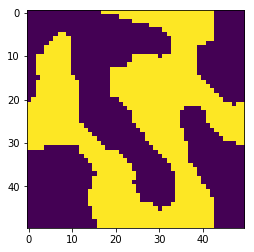

In [104]:
plt.imshow(mat[1:-1,1:-1])

In [146]:
simulate(mat,2.1,100)

In [223]:
Temps = np.arange(1.5,3.0,0.1)

In [225]:
samples = 50
L=20
steps = 400
tester=zip(Temps,repeat(L),repeat(steps),repeat(samples),repeat(valid_data))
p = mp.Pool(4)
#p.map(run_one, Temps)
p.starmap(generateSamples, tester)
p.close()
p.join()


In [200]:
samples = 3
L=20
steps = 3
for T in Temps:
    generateSamples(T,L,steps,samples,train_data)


100%|██████████| 3/3 [00:00<00:00, 73.11it/s]

In [201]:
data_files=os.listdir(train_data)

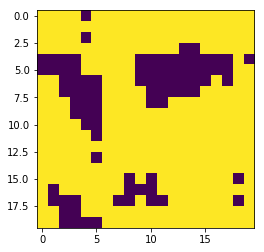

In [203]:
sampleMat=np.load(os.path.join(train_data,data_files[20]))
plt.imshow(sampleMat)

In [134]:
steps=500
avgE = np.zeros(steps)
for step in tqdm(range(steps)):
    mat,avgE[step]=iterate(mat,1.2)    

100%|██████████| 500/500 [00:15<00:00, 32.03it/s]


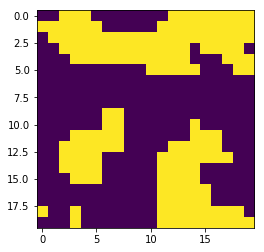

In [180]:
plt.imshow(mat[1:-1,1:-1])

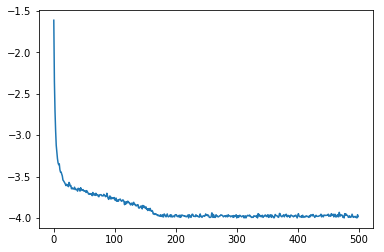

In [72]:
plt.plot(avgE)